In [187]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [188]:
pd.options.display.float_format = '{:.2f}'.format


In [189]:
# Importando dados de Excel com população por estado 
df_pop = pd.read_excel("dados\estimativa_dou_2020.xls", sheet_name='BRASIL E UFs', skiprows=1, skipfooter=7, usecols=['BRASIL E UNIDADES DA FEDERAÇÃO', 'POPULAÇÃO ESTIMADA'])

# Importando dados de gastos 
df_gastos = pd.read_csv(
    "C:\\Users\\corpc34475\\OneDrive - CVC Brasil Operadora e Agencia de Viagens S.A\\projetos\\estudo\\pos-tech-data-analytics\\fase_1\\analise_exploratoria_de_dados\\aula_5\\A150850189_28_143_208 (1).csv", 
    sep=';', 
    encoding='latin', 
    skiprows=3,
    skipfooter=12,
    na_values=['-'],
    decimal=','
)

C:\Users\corpc34475\AppData\Local\Temp\ipykernel_13548\3896088153.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_gastos = pd.read_csv(


In [190]:
# Renomeando colunas
df_pop.columns = ['uf','populacao_estimada']

In [191]:
# Criando coluna de id das regiões

x = 0
list_cat = []
for i in df_pop['uf']:
    if i.find('Região') >= 0:
        x += 1
        list_cat.append(x)

    else:
        list_cat.append(x)

print(list_cat)

df_pop['regiao_id'] = list_cat

[0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5]


In [192]:
# Removendo linhas com dados do Brasil e regiões
df_pop_estados = df_pop[~((df_pop['uf'].str.contains("Região")) | (df_pop['uf'] == 'Brasil'))].reset_index(drop=True)

df_regiao = df_pop[((df_pop['uf'].str.contains("Região")) | (df_pop['uf'] == 'Brasil'))].reset_index(drop=True)[['regiao_id','uf']].rename(columns={'uf':'regiao'})

df_pop_estados = df_pop_estados.set_index('regiao_id').join(other=df_regiao.set_index('regiao_id'), on='regiao_id', how='left').reset_index()

In [193]:
# Tratando colunas
df_pop_estados['populacao_estimada'] = df_pop_estados['populacao_estimada'].astype('str').str.replace(pat='\(\d*\)', repl='', regex=True).str.replace(pat='.', repl='', regex=True).astype('int')

# Adicionando uma coluna na primeira posição do DF
df_gastos.insert(loc=0, column='uf', value=df_gastos['Unidade da Federação'].str.replace(pat='^\d*\s', repl='', regex=True), allow_duplicates=True)

In [194]:
# Adicionando estimativa da população ao DF de gastos
df_complete = df_gastos.set_index('uf').join(other=df_pop_estados.set_index('uf'), on='uf', how='left').reset_index()

In [195]:
# Função para devolver a lista de colunas de meses
def list_last_months(df_months, qtd_months, lag:int=0):
    if lag == 0:
        ls_result = df_months.drop(columns=['uf','Unidade da Federação','Total','regiao_id','populacao_estimada','regiao']).columns[-qtd_months:]
    elif lag > 0:
        ls_result = df_months.drop(columns=['uf','Unidade da Federação','Total','regiao_id','populacao_estimada','regiao']).columns[-(lag+1)*qtd_months:-qtd_months]

    return ls_result

In [196]:
# Criando novas colunas
df_complete['gastos_2021ago_por_pessoa'] = df_complete['2021/Ago'] / df_complete['populacao_estimada']
df_complete['gastos_2021jul_por_pessoa'] = df_complete['2021/Jul'] / df_complete['populacao_estimada']

df_complete['gastos_last12_mes'] = df_complete[list_last_months(df_months=df_complete, qtd_months=12)].apply(np.sum, axis='columns')
df_complete['gastos_last12_mes_lag1'] = df_complete[list_last_months(df_months=df_complete, qtd_months=12, lag=1)].apply(np.sum, axis='columns')

# Selecionando colunas importantes
df_complete = df_complete[['uf','2021/Jul','2021/Ago','gastos_last12_mes','gastos_last12_mes_lag1','gastos_2021jul_por_pessoa','gastos_2021ago_por_pessoa','populacao_estimada','regiao']].set_index('uf')


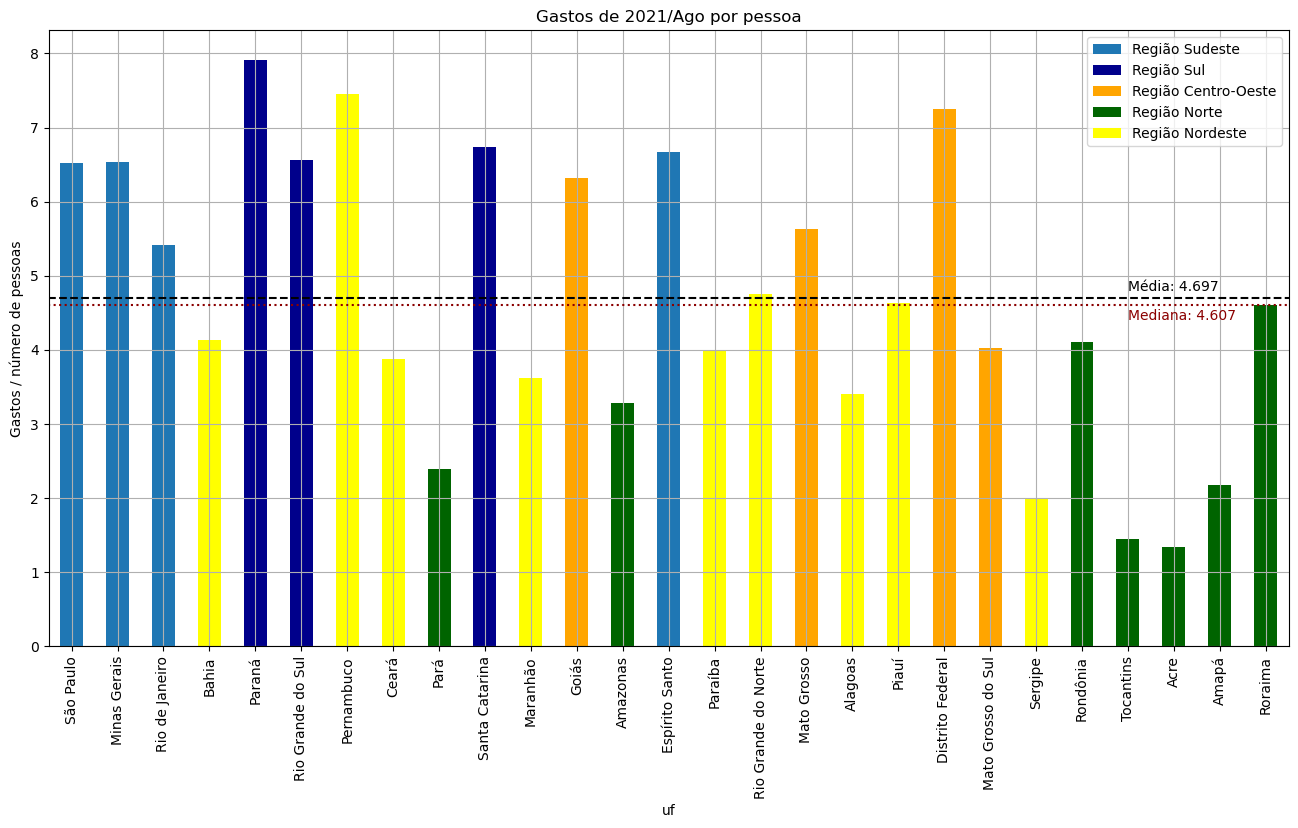

In [197]:
media_gastos_pessoa = df_complete['gastos_2021ago_por_pessoa'].mean()
mediana_gastos_pessoa = df_complete['gastos_2021ago_por_pessoa'].median()

ax = df_complete.sort_values(by='populacao_estimada', ascending=False)['gastos_2021ago_por_pessoa'].plot(kind='bar', figsize=(16,8))
ax.set_title("Gastos de 2021/Ago por pessoa")
ax.set_ylabel("Gastos / número de pessoas")


# Adicionando outra cores para as regiões
df_complete.sort_values(by='populacao_estimada', ascending=False).where(df_complete['regiao'] == 'Região Sul')['gastos_2021ago_por_pessoa'].plot(kind='bar', figsize=(16,8), color='darkblue')
df_complete.sort_values(by='populacao_estimada', ascending=False).where(df_complete['regiao'] == 'Região Centro-Oeste')['gastos_2021ago_por_pessoa'].plot(kind='bar', figsize=(16,8), color='orange')
df_complete.sort_values(by='populacao_estimada', ascending=False).where(df_complete['regiao'] == 'Região Norte')['gastos_2021ago_por_pessoa'].plot(kind='bar', figsize=(16,8), color='darkgreen')
df_complete.sort_values(by='populacao_estimada', ascending=False).where(df_complete['regiao'] == 'Região Nordeste')['gastos_2021ago_por_pessoa'].plot(kind='bar', figsize=(16,8), color='yellow')
ax.legend(['Região Sudeste','Região Sul','Região Centro-Oeste','Região Norte','Região Nordeste'])
ax.grid(True)

# Adicionando linha horizantal com a média
plt.plot([-1,100], [media_gastos_pessoa, media_gastos_pessoa], ls='dashed', color='black')
plt.annotate(f"Média: {round(media_gastos_pessoa,3)}", xy=(23,media_gastos_pessoa+.1), color='black')

# Adicionando linha horizantal com a mediana
plt.plot([-1,100], [mediana_gastos_pessoa, mediana_gastos_pessoa], ls='dotted', color='darkred')
plt.annotate(f"Mediana: {round(mediana_gastos_pessoa,3)}", xy=(23,mediana_gastos_pessoa-.2), color='darkred')

plt.show()


In [198]:
df_complete

,2021/Jul,2021/Ago,gastos_last12_mes,gastos_last12_mes_lag1,gastos_2021jul_por_pessoa,gastos_2021ago_por_pessoa,populacao_estimada,regiao
uf,,,,,,,,
Rondônia,11834435.10,7371334.84,119077462.96,109398620.08,6.59,4.10,1796460,Região Norte
Acre,2302711.01,1196754.85,35265456.80,40498871.15,2.57,1.34,894470,Região Norte
Amazonas,21614943.55,13806958.66,210961589.27,218310219.65,5.14,3.28,4207714,Região Norte
Roraima,3320807.96,2907871.07,35425710.94,36865268.34,5.26,4.61,631181,Região Norte
Pará,33718084.12,20837865.89,370225082.42,450268671.07,3.88,2.40,8690745,Região Norte
Amapá,4136950.62,1875241.91,35186145.89,30342246.04,4.80,2.18,861773,Região Norte
Tocantins,4610170.61,2304080.49,70702362.95,95238156.68,2.90,1.45,1590248,Região Norte
Maranhão,37775425.78,25779674.83,387185213.94,383769259.40,5.31,3.62,7114598,Região Nordeste
Piauí,19972846.10,15220885.72,229670498.52,226053408.92,6.09,4.64,3281480,Região Nordeste


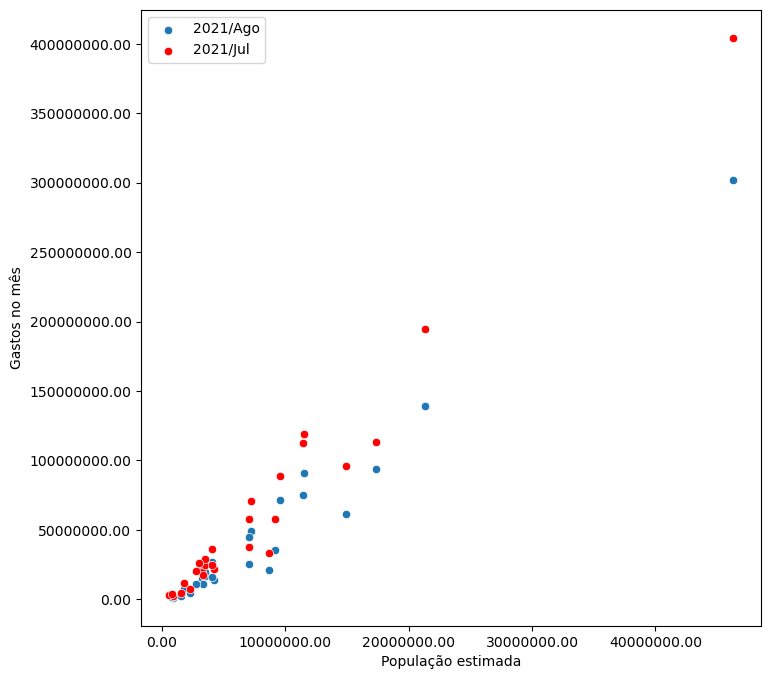

In [202]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=df_complete, x='populacao_estimada', y='2021/Ago')
ax2 = sns.scatterplot(data=df_complete, x='populacao_estimada', y='2021/Jul', color='red')
ax.set_ylabel("Gastos no mês")
ax.set_xlabel("População estimada")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.legend(['2021/Ago','2021/Jul'])

plt.show()

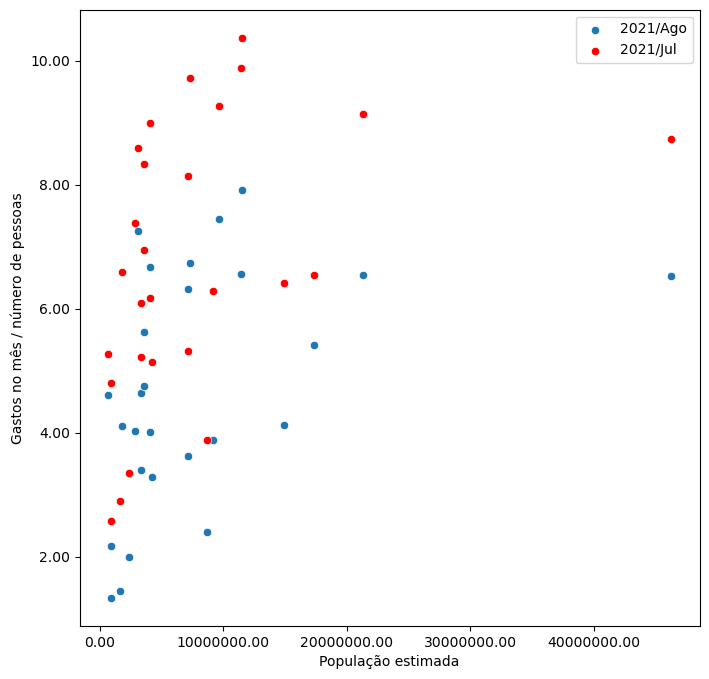

In [80]:
fig = plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=df_complete, x='populacao_estimada', y='gastos_2021ago_por_pessoa')
ax2 = sns.scatterplot(data=df_complete, x='populacao_estimada', y='gastos_2021jul_por_pessoa', color='red')
ax.set_ylabel("Gastos no mês / número de pessoas")
ax.set_xlabel("População estimada")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.legend(['2021/Ago','2021/Jul'])

plt.show()

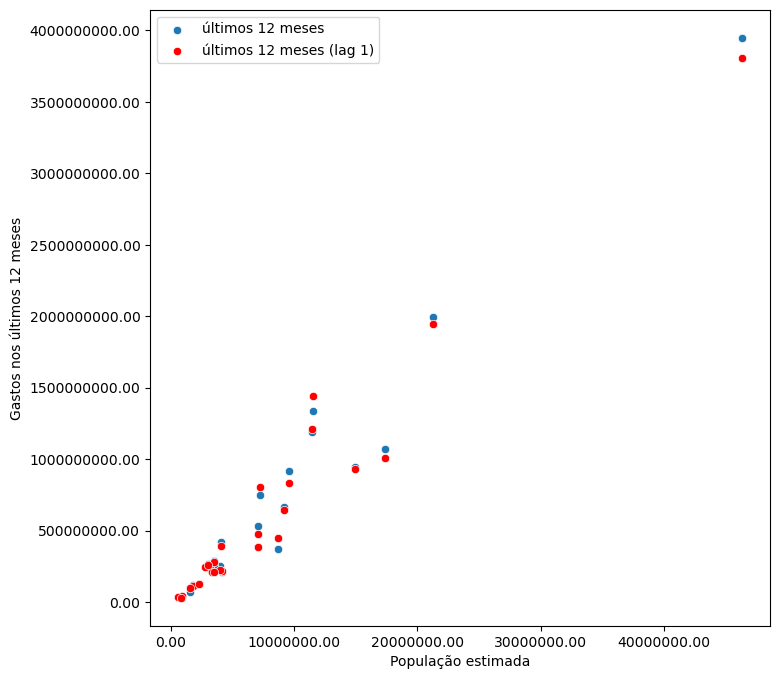

In [203]:
fig = plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=df_complete, x='populacao_estimada', y='gastos_last12_mes')
ax2 = sns.scatterplot(data=df_complete, x='populacao_estimada', y='gastos_last12_mes_lag1', color='red')
ax.set_ylabel("Gastos nos últimos 12 meses")
ax.set_xlabel("População estimada")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.legend(['últimos 12 meses','últimos 12 meses (lag 1)'])

plt.show()

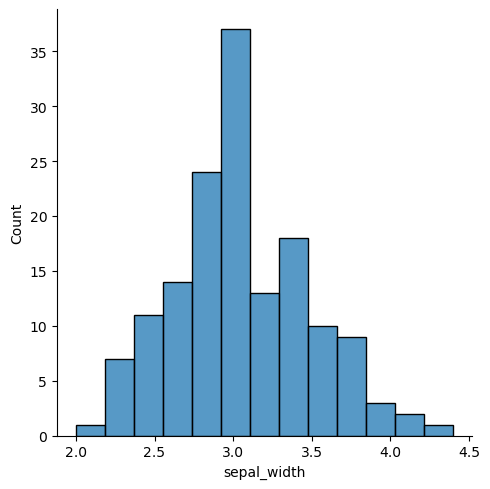

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar o dataset de exemplo iris
iris = sns.load_dataset("iris")

# Criar um gráfico de distribuição usando o atributo "sepal_width"
sns.displot(iris["sepal_width"])

# Mostrar o gráfico
plt.show()

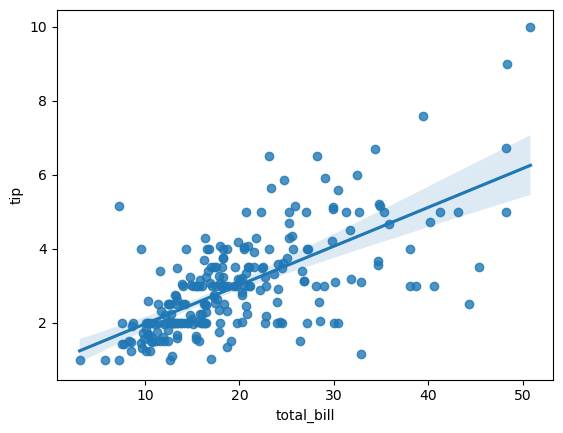

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar o dataset de exemplo tips
tips = sns.load_dataset("tips")

# Criar um gráfico de regressão linear usando "total_bill" como variável independente e "tip" como variável dependente
sns.regplot(x="total_bill", y="tip", data=tips)

# Mostrar o gráfico
plt.show()

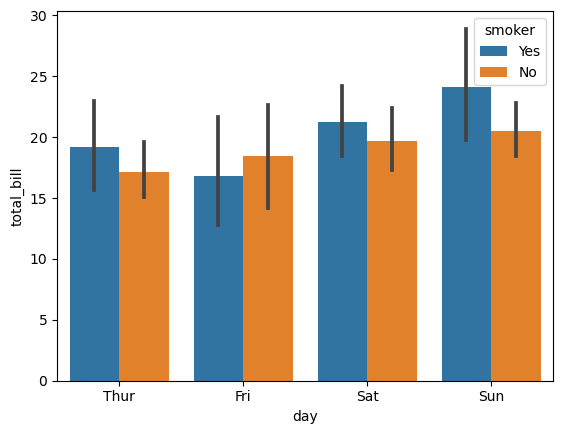

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar o dataset de exemplo tips
tips = sns.load_dataset("tips")

# Criar um gráfico de barra agrupado por "smoker" e "day"
sns.barplot(x="day", y="total_bill", hue="smoker", data=tips)

# Mostrar o gráfico
plt.show()